In [1]:
# %%
# ============================================================
# 1. Setup & Data Loading
# ============================================================

import os, sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Extend path so utils are importable
# Removed old path hack; using package imports, "../..")))

from llm_prior_project.data.causal_selector_utils import select_causal_features
from llm_prior_project.models.target_informed_model import TargetInformedModel

# ------------------------------------------------------------
# Load and inspect data
# ------------------------------------------------------------
df = pd.read_csv("diabetes.csv")
print(df.shape)
df.head()

# Basic info
df.info()
df.describe()


ModuleNotFoundError: No module named 'llm_prior_project.models.target_informed_model'

In [65]:
# %%
# ============================================================
# 2. Data Cleaning and Group Splitting
# ============================================================

# Columns where 0 means missing
missing_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[missing_cols] = df[missing_cols].replace(0, np.nan)

# Add missingness indicators
df["Missing_Insulin"] = df["Insulin"].isna().astype(int)
df["Missing_Skin"] = df["SkinThickness"].isna().astype(int)

# Impute with median
df[missing_cols] = df[missing_cols].fillna(df[missing_cols].median())

# Split: Young vs Old
age_threshold = df["Age"].median()
mask_young = df["Age"] < age_threshold
mask_old = ~mask_young

X_young = df.loc[mask_young].drop(columns="Outcome")
y_young = df.loc[mask_young, "Outcome"]

X_old = df.loc[mask_old].drop(columns="Outcome")
y_old = df.loc[mask_old, "Outcome"]

print(f"Young group: {X_young.shape}, Old group: {X_old.shape}")

# Scale (fit on combined)
scaler = StandardScaler().fit(pd.concat([X_young, X_old], axis=0))
X_young_scaled = scaler.transform(X_young)
X_old_scaled = scaler.transform(X_old)

print(df["Age"].median())


Young group: (367, 10), Old group: (401, 10)
29.0


In [53]:
# %%
# ============================================================
# 3. Setup — Baseline Ridge vs Target-Informed Ridge
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

from llm_prior_project.models.target_informed_model import TargetInformedModel

# Feature names
feature_names = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age',
    'Missing_Insulin', 'Missing_Skin'
]

# Domain-informed coefficient targets (for target-informed shrinkage)
target_vector_young = np.array([
    0.20,  # Pregnancies
    1.30,  # Glucose
    0.30,  # BloodPressure
    0.15,  # SkinThickness
    0.20,  # Insulin
    0.80,  # BMI
    0.60,  # DiabetesPedigreeFunction
    0.20,  # Age
    0.05,  # Missing_Insulin
    0.05   # Missing_Skin
])

target_vector_old = np.array([
    0.35,  # Pregnancies
    1.40,  # Glucose
    0.50,  # BloodPressure
    0.10,  # SkinThickness
    0.30,  # Insulin
    0.90,  # BMI
    0.40,  # DiabetesPedigreeFunction
    0.60,  # Age
    0.10,  # Missing_Insulin
    0.05   # Missing_Skin
])



In [54]:
# %%
# ============================================================
# 4. Compare Baseline Ridge vs Target-Informed Ridge
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

# ------------------------------------------------------------
# Helper: evaluate both models for one scenario
# ------------------------------------------------------------
def evaluate_ridge_models(scenario, X_train, y_train, X_test, y_test,
                          feature_names, targets, alphas):
    """
    Compare baseline logistic ridge vs target-informed ridge for one scenario.
    Returns DataFrame with metrics.
    """
    results = []

    for alpha in alphas:
        # --- (1) Baseline Ridge (standard logistic regression with L2) ---
        base = LogisticRegression(
            penalty="l2",
            C=1 / alpha if alpha > 0 else 1e6,
            solver="lbfgs",
            max_iter=2000
        )
        base.fit(X_train, y_train)
        p_base = base.predict_proba(X_test)[:, 1]
        results.append({
            "Scenario": scenario,
            "Model": "Baseline Ridge",
            "Alpha": alpha,
            "AUC": roc_auc_score(y_test, p_base),
            "Accuracy": accuracy_score(y_test, (p_base >= 0.5)),
            "LogLoss": log_loss(y_test, p_base)
        })

        # --- (2) Target-Informed Ridge ---
        tim = TargetInformedModel(
            alpha=alpha,
            model_type="logistic",
            targets=targets
        )
        tim.fit(X_train, y_train, feature_names=feature_names)
        p_tim = tim.predict(X_test)
        results.append({
            "Scenario": scenario,
            "Model": "Target-Informed Ridge",
            "Alpha": alpha,
            "AUC": roc_auc_score(y_test, p_tim),
            "Accuracy": accuracy_score(y_test, (p_tim >= 0.5)),
            "LogLoss": log_loss(y_test, p_tim)
        })

    return pd.DataFrame(results)


# ------------------------------------------------------------
# Run both models for each scenario
# ------------------------------------------------------------
alphas = np.linspace(0, 500, 10)
all_results = []

scenarios = {
    "YOUNG→OLD": (X_young_scaled, y_young, X_old_scaled, y_old, target_vector_old),
    "OLD→YOUNG": (X_old_scaled, y_old, X_young_scaled, y_young, target_vector_young),
}

for scenario_name, (X_train, y_train, X_test, y_test, targets) in scenarios.items():
    print(f"\n=== Running {scenario_name} ===")
    df_tmp = evaluate_ridge_models(
        scenario_name,
        X_train, y_train, X_test, y_test,
        feature_names, targets, alphas
    )
    all_results.append(df_tmp)

df_ridge = pd.concat(all_results, ignore_index=True)

print("\n✓ Completed baseline vs target-informed ridge comparison.")
print(df_ridge.groupby("Scenario")["Model"].count())
print(df_ridge.head())



=== Running YOUNG→OLD ===

=== Running OLD→YOUNG ===

✓ Completed baseline vs target-informed ridge comparison.
Scenario
OLD→YOUNG    20
YOUNG→OLD    20
Name: Model, dtype: int64
    Scenario                  Model       Alpha       AUC  Accuracy   LogLoss
0  YOUNG→OLD         Baseline Ridge    0.000000  0.719568  0.665835  0.741138
1  YOUNG→OLD  Target-Informed Ridge    0.000000  0.719593  0.665835  0.741271
2  YOUNG→OLD         Baseline Ridge   55.555556  0.763462  0.556110  0.705888
3  YOUNG→OLD  Target-Informed Ridge   55.555556  0.755275  0.668329  0.641589
4  YOUNG→OLD         Baseline Ridge  111.111111  0.763387  0.503741  0.749007


In [55]:
# %%
# ============================================================
# 4b. Inspect & Summarize Results Clearly
# ============================================================

import pandas as pd
import numpy as np

# 1) Sanity checks
print("\n=== Scenarios present ===")
print(df_ridge["Scenario"].value_counts())

print("\n=== Models present ===")
print(df_ridge["Model"].value_counts())

# 2) Show first 3 rows per scenario/model (not just head())
print("\n=== Sample rows per scenario/model ===")
for sc in ["YOUNG→OLD", "OLD→YOUNG"]:
    for m in ["Baseline Ridge", "Target-Informed Ridge"]:
        d = df_ridge[(df_ridge["Scenario"] == sc) & (df_ridge["Model"] == m)]
        print(f"\n[{sc} | {m}] (showing first 3)")
        print(d.sort_values("Alpha").head(3)[["Scenario","Model","Alpha","AUC","Accuracy","LogLoss"]])

# 3) Best α per model & scenario
best = (
    df_ridge.loc[df_ridge.groupby(["Scenario","Model"])["AUC"].idxmax()]
    .sort_values(["Scenario","Model"])
    .reset_index(drop=True)
)
print("\n=== Best AUC per Model & Scenario ===")
print(best[["Scenario","Model","Alpha","AUC","Accuracy","LogLoss"]])

# 4) Same-α deltas (compare models at identical α values)
def same_alpha_deltas(df, scenario):
    d = df[df["Scenario"] == scenario]
    b = d[d["Model"] == "Baseline Ridge"].set_index("Alpha")
    t = d[d["Model"] == "Target-Informed Ridge"].set_index("Alpha")
    common = b.index.intersection(t.index)
    comp = pd.DataFrame({
        "AUC_base": b.loc[common, "AUC"],
        "AUC_tim":  t.loc[common, "AUC"],
        "ΔAUC":     t.loc[common, "AUC"] - b.loc[common, "AUC"],
        "Acc_base": b.loc[common, "Accuracy"],
        "Acc_tim":  t.loc[common, "Accuracy"],
        "ΔAcc":     t.loc[common, "Accuracy"] - b.loc[common, "Accuracy"],
        "LL_base":  b.loc[common, "LogLoss"],
        "LL_tim":   t.loc[common, "LogLoss"],
        "ΔLogLoss": b.loc[common, "LogLoss"] - t.loc[common, "LogLoss"],
    }).reset_index().rename(columns={"Alpha":"α"})
    return comp.sort_values("α")

print("\n=== Same-α comparison: YOUNG→OLD ===")
print(same_alpha_deltas(df_ridge, "YOUNG→OLD").to_string(index=False))

print("\n=== Same-α comparison: OLD→YOUNG ===")
print(same_alpha_deltas(df_ridge, "OLD→YOUNG").to_string(index=False))

# 5) Quick guidance if everything looks identical at small α
min_alpha = df_ridge["Alpha"].min()
if min_alpha <= 1e-3:
    print("\nNote: very small α values make L2 effects tiny; if deltas are ~0,")
    print("try examining larger α (≥ 0.1 or 1) or make the target_vector more distinct.")



=== Scenarios present ===
Scenario
YOUNG→OLD    20
OLD→YOUNG    20
Name: count, dtype: int64

=== Models present ===
Model
Baseline Ridge           20
Target-Informed Ridge    20
Name: count, dtype: int64

=== Sample rows per scenario/model ===

[YOUNG→OLD | Baseline Ridge] (showing first 3)
    Scenario           Model       Alpha       AUC  Accuracy   LogLoss
0  YOUNG→OLD  Baseline Ridge    0.000000  0.719568  0.665835  0.741138
2  YOUNG→OLD  Baseline Ridge   55.555556  0.763462  0.556110  0.705888
4  YOUNG→OLD  Baseline Ridge  111.111111  0.763387  0.503741  0.749007

[YOUNG→OLD | Target-Informed Ridge] (showing first 3)
    Scenario                  Model       Alpha       AUC  Accuracy   LogLoss
1  YOUNG→OLD  Target-Informed Ridge    0.000000  0.719593  0.665835  0.741271
3  YOUNG→OLD  Target-Informed Ridge   55.555556  0.755275  0.668329  0.641589
5  YOUNG→OLD  Target-Informed Ridge  111.111111  0.756942  0.675810  0.647552

[OLD→YOUNG | Baseline Ridge] (showing first 3)
     Sc

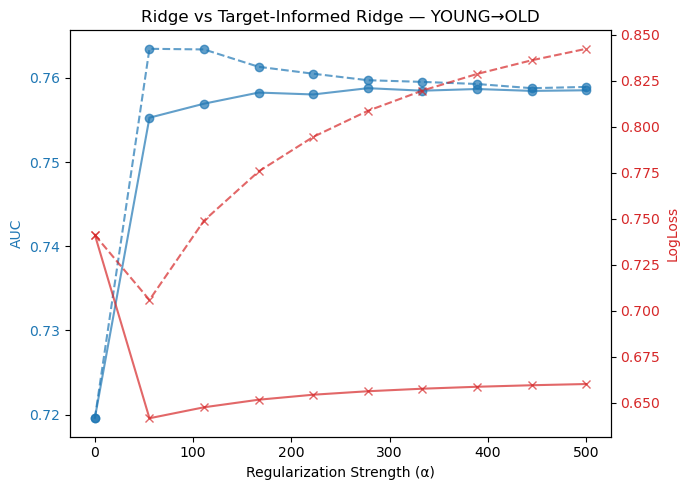

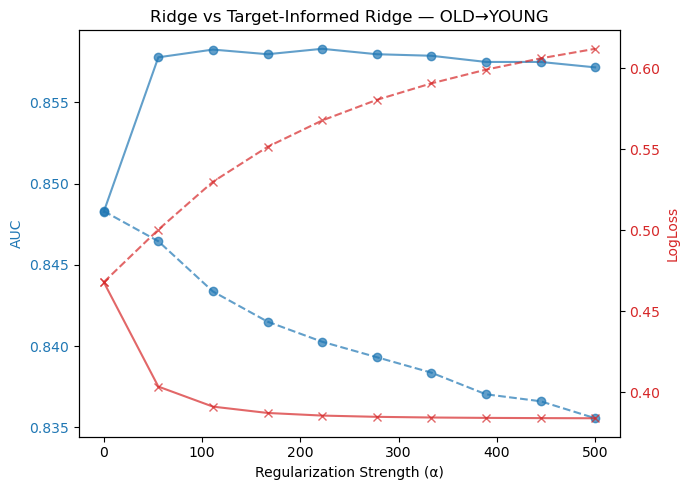

In [56]:
# %%
# ============================================================
# 5. Visualization — AUC and LogLoss vs α
# ============================================================

import matplotlib.pyplot as plt

def plot_auc_logloss(df, scenario):
    """Plot AUC and LogLoss vs α for both models in a given scenario."""
    d = df[df["Scenario"] == scenario]
    
    fig, ax1 = plt.subplots(figsize=(7,5))
    
    # --- AUC (left y-axis) ---
    ax1.set_xlabel("Regularization Strength (α)")
    ax1.set_ylabel("AUC", color="tab:blue")
    for model, style in zip(["Baseline Ridge", "Target-Informed Ridge"], ["--o", "-o"]):
        dm = d[d["Model"] == model].sort_values("Alpha")
        ax1.plot(dm["Alpha"], dm["AUC"], style, color="tab:blue", alpha=0.7, label=f"{model} (AUC)")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    
    # --- LogLoss (right y-axis) ---
    ax2 = ax1.twinx()
    ax2.set_ylabel("LogLoss", color="tab:red")
    for model, style in zip(["Baseline Ridge", "Target-Informed Ridge"], ["--x", "-x"]):
        dm = d[d["Model"] == model].sort_values("Alpha")
        ax2.plot(dm["Alpha"], dm["LogLoss"], style, color="tab:red", alpha=0.7, label=f"{model} (LogLoss)")
    ax2.tick_params(axis="y", labelcolor="tab:red")
    
    # --- Title & layout ---
    plt.title(f"Ridge vs Target-Informed Ridge — {scenario}")
    fig.tight_layout()
    plt.show()

# Run for both directions
plot_auc_logloss(df_ridge, "YOUNG→OLD")
plot_auc_logloss(df_ridge, "OLD→YOUNG")



Best α values (Target-Informed Ridge): YOUNG→OLD=55.556, OLD→YOUNG=222.222
Best α values (Baseline Ridge):        YOUNG→OLD=55.556, OLD→YOUNG=0.000

=== Cross-Validation Performance (Target-Informed Ridge) ===
YOUNG→OLD:  AUC=0.855±0.031, Acc=0.842±0.014, LogLoss=0.355±0.021
OLD→YOUNG:  AUC=0.784±0.042, Acc=0.711±0.043, LogLoss=0.601±0.059


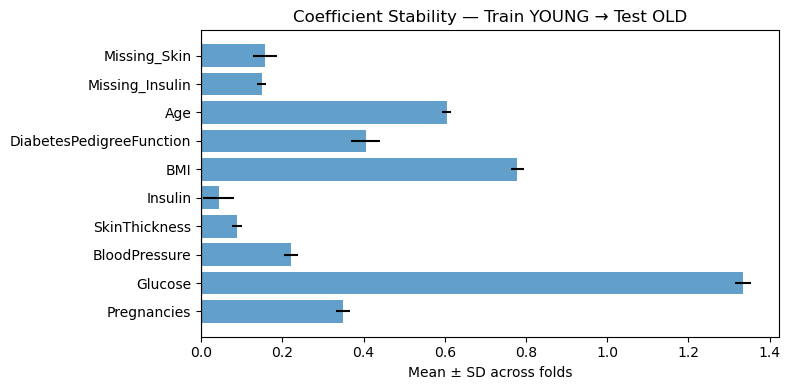

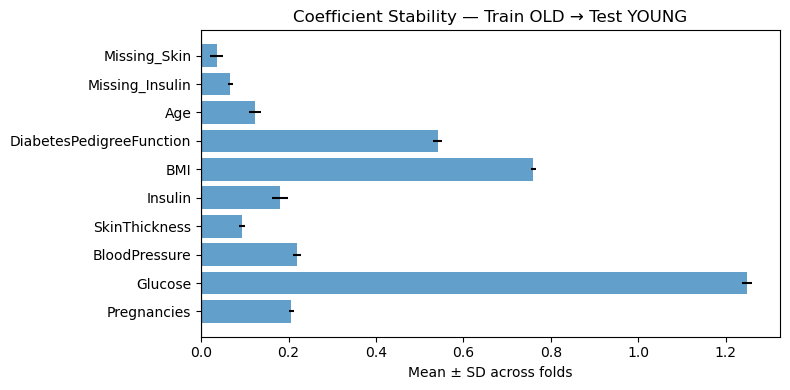

In [62]:
# %%
# ============================================================
# 6. Cross-Validation & Coefficient Stability — Target-Informed Ridge
# ============================================================

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def crossval_target_informed(X, y, feature_names, target_vector, alpha, n_splits=5):
    """
    5-fold cross-validation for Target-Informed Ridge (logistic variant).
    Returns mean±std of metrics and per-fold coefficients.
    """
    y = np.asarray(y)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    aucs, accs, losses, coefs = [], [], [], []

    for train_idx, test_idx in kf.split(X):
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]

        model = TargetInformedModel(
            alpha=alpha,
            model_type="logistic",
            targets=target_vector
        )
        model.fit(X_tr, y_tr, feature_names=feature_names)
        p = model.predict(X_te)

        aucs.append(roc_auc_score(y_te, p))
        accs.append(accuracy_score(y_te, (p >= 0.5)))
        losses.append(log_loss(y_te, p))
        coefs.append(model.coef_)  # <-- direct access

    return {
        "AUC_mean": np.mean(aucs), "AUC_std": np.std(aucs),
        "Acc_mean": np.mean(accs), "Acc_std": np.std(accs),
        "LogLoss_mean": np.mean(losses), "LogLoss_std": np.std(losses),
        "Coef_matrix": np.array(coefs),
        "Feature_names": feature_names,
    }

# ------------------------------------------------------------
# Extract best α values for BOTH model types from earlier sweep
# ------------------------------------------------------------

# --- Target-Informed Ridge (original logic) ---
alpha_best_y2o_tim = (
    df_ridge[df_ridge["Scenario"] == "YOUNG→OLD"]
    .sort_values("AUC", ascending=False)
    .iloc[0]["Alpha"]
)
alpha_best_o2y_tim = (
    df_ridge[df_ridge["Scenario"] == "OLD→YOUNG"]
    .sort_values("AUC", ascending=False)
    .iloc[0]["Alpha"]
)

# --- Baseline Ridge (new logic) ---
def get_best_baseline_alpha(df_ridge, scenario_name):
    """Return α giving best AUC for Baseline Ridge in a given scenario."""
    df_base = df_ridge[
        (df_ridge["Scenario"] == scenario_name)
        & (df_ridge["Model"] == "Baseline Ridge")
    ]
    if df_base.empty:
        print(f"⚠️ No baseline Ridge rows found for {scenario_name}; using α=1.0 as fallback.")
        return 1.0
    best_row = df_base.loc[df_base["AUC"].idxmax()]
    return float(best_row["Alpha"])

alpha_best_y2o_base = get_best_baseline_alpha(df_ridge, "YOUNG→OLD")
alpha_best_o2y_base = get_best_baseline_alpha(df_ridge, "OLD→YOUNG")

print(f"\nBest α values (Target-Informed Ridge): "
      f"YOUNG→OLD={alpha_best_y2o_tim:.3f}, OLD→YOUNG={alpha_best_o2y_tim:.3f}")
print(f"Best α values (Baseline Ridge):        "
      f"YOUNG→OLD={alpha_best_y2o_base:.3f}, OLD→YOUNG={alpha_best_o2y_base:.3f}")

# Store both sets for later reuse (e.g., causal experiments)
best_alphas = {
    "target_informed": {"YOUNG→OLD": alpha_best_y2o_tim, "OLD→YOUNG": alpha_best_o2y_tim},
    "baseline": {"YOUNG→OLD": alpha_best_y2o_base, "OLD→YOUNG": alpha_best_o2y_base}
}

# ------------------------------------------------------------
# Run 5-fold CV within each training group (using TIM best α)
# ------------------------------------------------------------
cv_y2o = crossval_target_informed(
    X_young_scaled, y_young, feature_names, target_vector_old, alpha_best_y2o_tim
)
cv_o2y = crossval_target_informed(
    X_old_scaled, y_old, feature_names, target_vector_young, alpha_best_o2y_tim
)

# ------------------------------------------------------------
# Display metrics
# ------------------------------------------------------------
print("\n=== Cross-Validation Performance (Target-Informed Ridge) ===")
print(f"YOUNG→OLD:  AUC={cv_y2o['AUC_mean']:.3f}±{cv_y2o['AUC_std']:.3f}, "
      f"Acc={cv_y2o['Acc_mean']:.3f}±{cv_y2o['Acc_std']:.3f}, "
      f"LogLoss={cv_y2o['LogLoss_mean']:.3f}±{cv_y2o['LogLoss_std']:.3f}")
print(f"OLD→YOUNG:  AUC={cv_o2y['AUC_mean']:.3f}±{cv_o2y['AUC_std']:.3f}, "
      f"Acc={cv_o2y['Acc_mean']:.3f}±{cv_o2y['Acc_std']:.3f}, "
      f"LogLoss={cv_o2y['LogLoss_mean']:.3f}±{cv_o2y['LogLoss_std']:.3f}")

# ------------------------------------------------------------
# Coefficient stability plots
# ------------------------------------------------------------
def plot_coef_stability(cv_result, title):
    coefs = cv_result["Coef_matrix"]
    features = cv_result["Feature_names"]
    coef_means = coefs.mean(axis=0)
    coef_stds = coefs.std(axis=0)

    plt.figure(figsize=(8,4))
    plt.barh(features, coef_means, xerr=coef_stds, alpha=0.7)
    plt.axvline(0, color="k", lw=0.8)
    plt.title(f"Coefficient Stability — {title}")
    plt.xlabel("Mean ± SD across folds")
    plt.tight_layout()
    plt.show()

plot_coef_stability(cv_y2o, "Train YOUNG → Test OLD")
plot_coef_stability(cv_o2y, "Train OLD → Test YOUNG")


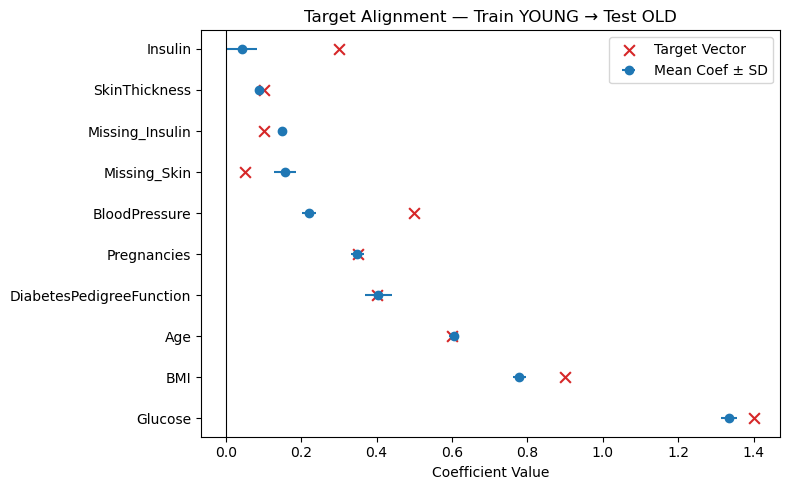

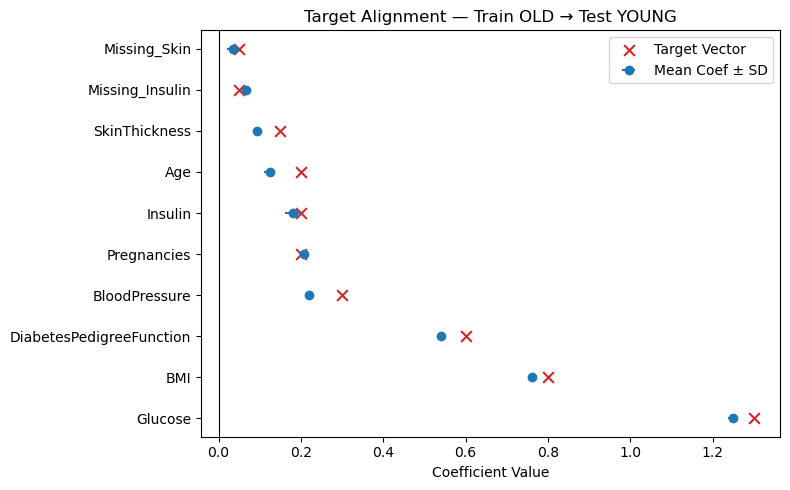

In [58]:
# %%
# ============================================================
# 7. Compare Mean Coefficients vs Target Vector
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

def plot_coef_vs_target(cv_result, target_vector, title):
    """
    Compare mean cross-validated coefficients with target vector values.
    """
    coefs = cv_result["Coef_matrix"]
    features = cv_result["Feature_names"]
    coef_means = coefs.mean(axis=0)
    coef_stds = coefs.std(axis=0)
    
    # Sort by absolute importance for clarity
    order = np.argsort(np.abs(coef_means))[::-1]
    features = np.array(features)[order]
    coef_means = coef_means[order]
    coef_stds = coef_stds[order]
    targets = np.array(target_vector)[order]
    
    plt.figure(figsize=(8,5))
    plt.errorbar(coef_means, features, xerr=coef_stds, fmt='o', color='tab:blue', label='Mean Coef ± SD')
    plt.scatter(targets, features, color='tab:red', marker='x', s=60, label='Target Vector')
    plt.axvline(0, color='k', lw=0.8)
    plt.title(f"Target Alignment — {title}")
    plt.xlabel("Coefficient Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# Plot for both directions
# ------------------------------------------------------------
plot_coef_vs_target(cv_y2o, target_vector_old, "Train YOUNG → Test OLD")
plot_coef_vs_target(cv_o2y, target_vector_young, "Train OLD → Test YOUNG")


In [63]:
# %%
# ============================================================
# 6. Causality-Guided Experiment — Baseline vs Target-Informed Ridge
# ============================================================

print("="*80)
print("CAUSALITY EXPERIMENT: Baseline Ridge vs Target-Informed Ridge")
print("="*80)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

feature_names = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age',
    'Missing_Insulin', 'Missing_Skin'
]

# Define causal subset
causal_features = ['Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
print(f"\nSelected causal features: {causal_features}")

# ------------------------------------------------------------
# Retrieve best α values from previous step
# ------------------------------------------------------------
try:
    alpha_base_y2o = best_alphas["baseline"]["YOUNG→OLD"]
    alpha_base_o2y = best_alphas["baseline"]["OLD→YOUNG"]
    alpha_tim_y2o  = best_alphas["target_informed"]["YOUNG→OLD"]
    alpha_tim_o2y  = best_alphas["target_informed"]["OLD→YOUNG"]
except Exception as e:
    print("⚠️ 'best_alphas' not found — falling back to α=1.0 for all.")
    alpha_base_y2o = alpha_base_o2y = alpha_tim_y2o = alpha_tim_o2y = 1.0

print("\nUsing α values:")
print(f"  BASELINE Ridge — YOUNG→OLD={alpha_base_y2o:.3f}, OLD→YOUNG={alpha_base_o2y:.3f}")
print(f"  TARGET-INFORMED Ridge — YOUNG→OLD={alpha_tim_y2o:.3f}, OLD→YOUNG={alpha_tim_o2y:.3f}")

# ------------------------------------------------------------
# Helper to select causal subset
# ------------------------------------------------------------
def select_causal_features(X, feature_names, causal_list):
    """Select features by name, return reduced matrix and indices."""
    idx = [i for i, f in enumerate(feature_names) if f in causal_list]
    kept = [feature_names[i] for i in idx]
    X_sel = X[:, idx]
    return X_sel, idx, kept

# ------------------------------------------------------------
# Scenario configuration
# ------------------------------------------------------------
scenarios = [
    {
        "name": "YOUNG→OLD",
        "X_train": X_young_scaled,
        "y_train": y_young,
        "X_test": X_old_scaled,
        "y_test": y_old,
        "alpha_base": alpha_base_y2o,
        "alpha_tim":  alpha_tim_y2o,
        "target_vector": target_vector_old,  # predicting OLD
    },
    {
        "name": "OLD→YOUNG",
        "X_train": X_old_scaled,
        "y_train": y_old,
        "X_test": X_young_scaled,
        "y_test": y_young,
        "alpha_base": alpha_base_o2y,
        "alpha_tim":  alpha_tim_o2y,
        "target_vector": target_vector_young,  # predicting YOUNG
    }
]

all_results = []

# ------------------------------------------------------------
# Run both directions
# ------------------------------------------------------------
for s in scenarios:
    print(f"\n{'='*80}\nScenario: {s['name']}\n{'='*80}")
    X_train, y_train = s["X_train"], s["y_train"]
    X_test, y_test   = s["X_test"], s["y_test"]
    alpha_base = s["alpha_base"]
    alpha_tim  = s["alpha_tim"]
    target_vector = s["target_vector"]

    # --------------------------------------------------------
    # (1) Baseline Ridge — all features
    # --------------------------------------------------------
    print(f"\n[1] Baseline Ridge (all features, α={alpha_base:.2f})")
    base = LogisticRegression(
        penalty="l2",
        C=1 / alpha_base if alpha_base > 0 else 1e6,
        solver="lbfgs",
        max_iter=2000
    )
    base.fit(X_train, y_train)
    p_base = base.predict_proba(X_test)[:, 1]
    mtr_base = {
        "AUC": roc_auc_score(y_test, p_base),
        "Accuracy": accuracy_score(y_test, (p_base >= 0.5)),
        "LogLoss": log_loss(y_test, p_base)
    }
    print(f"AUC={mtr_base['AUC']:.3f}, Acc={mtr_base['Accuracy']:.3f}, LogLoss={mtr_base['LogLoss']:.3f}")
    all_results.append({
        "Scenario": s["name"], "Strategy": "Baseline Ridge (all)",
        "Num_Features": len(feature_names), **mtr_base
    })

    # --------------------------------------------------------
    # (2) Target-Informed Ridge — all features
    # --------------------------------------------------------
    print(f"\n[2] Target-Informed Ridge (all features, α={alpha_tim:.2f})")
    tim_all = TargetInformedModel(
        alpha=alpha_tim,
        model_type="logistic",
        targets=target_vector
    )
    tim_all.fit(X_train, y_train, feature_names=feature_names)
    p_tim_all = tim_all.predict(X_test)
    mtr_tim_all = {
        "AUC": roc_auc_score(y_test, p_tim_all),
        "Accuracy": accuracy_score(y_test, (p_tim_all >= 0.5)),
        "LogLoss": log_loss(y_test, p_tim_all)
    }
    print(f"AUC={mtr_tim_all['AUC']:.3f}, Acc={mtr_tim_all['Accuracy']:.3f}, LogLoss={mtr_tim_all['LogLoss']:.3f}")
    all_results.append({
        "Scenario": s["name"], "Strategy": f"Target-Informed Ridge (α={alpha_tim:.2f}, all)",
        "Num_Features": len(feature_names), **mtr_tim_all
    })

    # --------------------------------------------------------
    # (3) Baseline Ridge + causal selector
    # --------------------------------------------------------
    print("\n[3] Baseline Ridge + causal selector")
    X_train_causal, idx, kept = select_causal_features(X_train, feature_names, causal_features)
    X_test_causal = X_test[:, idx]
    base_causal = LogisticRegression(
        penalty="l2",
        C=1 / alpha_base if alpha_base > 0 else 1e6,
        solver="lbfgs",
        max_iter=2000
    )
    base_causal.fit(X_train_causal, y_train)
    p_base_causal = base_causal.predict_proba(X_test_causal)[:, 1]
    mtr_base_causal = {
        "AUC": roc_auc_score(y_test, p_base_causal),
        "Accuracy": accuracy_score(y_test, (p_base_causal >= 0.5)),
        "LogLoss": log_loss(y_test, p_base_causal)
    }
    print(f"AUC={mtr_base_causal['AUC']:.3f}, Acc={mtr_base_causal['Accuracy']:.3f}, LogLoss={mtr_base_causal['LogLoss']:.3f}")
    all_results.append({
        "Scenario": s["name"], "Strategy": "Baseline Ridge (causal)",
        "Num_Features": len(kept), **mtr_base_causal
    })

    # --------------------------------------------------------
    # (4) Target-Informed Ridge + causal selector
    # --------------------------------------------------------
    print(f"\n[4] Target-Informed Ridge + causal selector (α={alpha_tim:.2f})")
    target_vector_causal = target_vector[idx]
    tim_causal = TargetInformedModel(
        alpha=alpha_tim,
        model_type="logistic",
        targets=target_vector_causal
    )
    tim_causal.fit(X_train_causal, y_train, feature_names=kept)
    p_tim_causal = tim_causal.predict(X_test_causal)
    mtr_tim_causal = {
        "AUC": roc_auc_score(y_test, p_tim_causal),
        "Accuracy": accuracy_score(y_test, (p_tim_causal >= 0.5)),
        "LogLoss": log_loss(y_test, p_tim_causal)
    }
    print(f"AUC={mtr_tim_causal['AUC']:.3f}, Acc={mtr_tim_causal['Accuracy']:.3f}, LogLoss={mtr_tim_causal['LogLoss']:.3f}")
    all_results.append({
        "Scenario": s["name"], "Strategy": f"Target-Informed Ridge (α={alpha_tim:.2f}, causal)",
        "Num_Features": len(kept), **mtr_tim_causal
    })

# ------------------------------------------------------------
# Summary table
# ------------------------------------------------------------
df_causal_ridge = pd.DataFrame(all_results)
print("\n" + "="*80)
print("SUMMARY OF CAUSALITY EXPERIMENT (RIDGE MODELS)")
print("="*80)
print(df_causal_ridge.to_string(index=False))

df_causal_ridge.to_csv("causality_experiment_ridge.csv", index=False)
print("\n✓ Results saved to causality_experiment_ridge.csv")


CAUSALITY EXPERIMENT: Baseline Ridge vs Target-Informed Ridge

Selected causal features: ['Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']

Using α values:
  BASELINE Ridge — YOUNG→OLD=55.556, OLD→YOUNG=0.000
  TARGET-INFORMED Ridge — YOUNG→OLD=55.556, OLD→YOUNG=222.222

Scenario: YOUNG→OLD

[1] Baseline Ridge (all features, α=55.56)
AUC=0.763, Acc=0.556, LogLoss=0.706

[2] Target-Informed Ridge (all features, α=55.56)
AUC=0.755, Acc=0.668, LogLoss=0.642

[3] Baseline Ridge + causal selector
AUC=0.790, Acc=0.526, LogLoss=0.743

[4] Target-Informed Ridge + causal selector (α=55.56)
AUC=0.788, Acc=0.676, LogLoss=0.695

Scenario: OLD→YOUNG

[1] Baseline Ridge (all features, α=0.00)
AUC=0.848, Acc=0.798, LogLoss=0.468

[2] Target-Informed Ridge (all features, α=222.22)
AUC=0.858, Acc=0.831, LogLoss=0.386

[3] Baseline Ridge + causal selector
AUC=0.853, Acc=0.809, LogLoss=0.452

[4] Target-Informed Ridge + causal selector (α=222.22)
AUC=0.852, Acc=0.812, LogLoss=0.448

SUMMARY OF CA

In [64]:
# %%
# ============================================================
# 7. Compute % Change vs Baseline (All Features)
# ============================================================

import pandas as pd
import numpy as np

print("="*80)
print("PERCENTAGE CHANGE VS BASELINE (ALL FEATURES)")
print("="*80)

# Copy to avoid modifying original
df_delta = df_causal_ridge.copy()

# Identify baseline rows
baseline_rows = df_delta[df_delta["Strategy"] == "Baseline Ridge (all)"]

deltas = []

for scenario in df_delta["Scenario"].unique():
    base = baseline_rows[baseline_rows["Scenario"] == scenario].iloc[0]

    for _, row in df_delta[df_delta["Scenario"] == scenario].iterrows():
        if row["Strategy"] == "Baseline Ridge (all)":
            continue  # skip baseline itself
        deltas.append({
            "Scenario": scenario,
            "Strategy": row["Strategy"],
            "ΔAUC_%": 100 * (row["AUC"] - base["AUC"]) / base["AUC"],
            "ΔAccuracy_%": 100 * (row["Accuracy"] - base["Accuracy"]) / base["Accuracy"],
            "ΔLogLoss_%": 100 * (base["LogLoss"] - row["LogLoss"]) / base["LogLoss"],  # lower is better
        })

df_deltas = pd.DataFrame(deltas)

# Round nicely
df_deltas = df_deltas.round(3)

print("\n=== Relative Change vs Baseline Ridge (All) ===")
print(df_deltas.to_string(index=False))

# Save for later reference
df_deltas.to_csv("causality_experiment_ridge_deltas.csv", index=False)
print("\n✓ Saved percentage change summary to causality_experiment_ridge_deltas.csv")


PERCENTAGE CHANGE VS BASELINE (ALL FEATURES)

=== Relative Change vs Baseline Ridge (All) ===
 Scenario                                 Strategy  ΔAUC_%  ΔAccuracy_%  ΔLogLoss_%
YOUNG→OLD     Target-Informed Ridge (α=55.56, all)  -1.072       20.179       9.109
YOUNG→OLD                  Baseline Ridge (causal)   3.416       -5.381      -5.203
YOUNG→OLD  Target-Informed Ridge (α=55.56, causal)   3.223       21.525       1.594
OLD→YOUNG    Target-Informed Ridge (α=222.22, all)   1.178        4.096      17.574
OLD→YOUNG                  Baseline Ridge (causal)   0.578        1.365       3.468
OLD→YOUNG Target-Informed Ridge (α=222.22, causal)   0.432        1.706       4.260

✓ Saved percentage change summary to causality_experiment_ridge_deltas.csv


In [61]:
# %%
# ============================================================
# 7. Compute % Change — Target-Informed (causal) vs Target-Informed (all)
# ============================================================

import pandas as pd
import numpy as np

print("="*80)
print("PERCENTAGE CHANGE — Target-Informed (causal) vs Target-Informed (all)")
print("="*80)

# Copy original results
df_delta = df_causal_ridge.copy()

# Identify relevant rows
all_rows = df_delta[df_delta["Strategy"].str.contains("Target-Informed Ridge") & df_delta["Strategy"].str.contains("all")]
causal_rows = df_delta[df_delta["Strategy"].str.contains("Target-Informed Ridge") & df_delta["Strategy"].str.contains("causal")]

deltas = []

for scenario in df_delta["Scenario"].unique():
    base_set = all_rows[all_rows["Scenario"] == scenario]
    causal_set = causal_rows[causal_rows["Scenario"] == scenario]

    if base_set.empty or causal_set.empty:
        print(f"⚠️ Skipping scenario '{scenario}' (missing one of the Target-Informed variants)")
        continue

    base = base_set.iloc[0]
    causal = causal_set.iloc[0]

    deltas.append({
        "Scenario": scenario,
        "ΔAUC_%": 100 * (causal["AUC"] - base["AUC"]) / base["AUC"],
        "ΔAccuracy_%": 100 * (causal["Accuracy"] - base["Accuracy"]) / base["Accuracy"],
        "ΔLogLoss_%": 100 * (base["LogLoss"] - causal["LogLoss"]) / base["LogLoss"],  # positive = improvement
    })

# Compile results
df_deltas_target = pd.DataFrame(deltas).round(3)

if not df_deltas_target.empty:
    print("\n=== Relative Change for Target-Informed Ridge (Causal vs All) ===")
    print(df_deltas_target.to_string(index=False))
else:
    print("\nNo valid Target-Informed Ridge (causal vs all) pairs found.")

# Save for later reference
df_deltas_target.to_csv("causality_experiment_ridge_deltas_target.csv", index=False)
print("\n✓ Saved percentage change summary to causality_experiment_ridge_deltas_target.csv")


PERCENTAGE CHANGE — Target-Informed (causal) vs Target-Informed (all)

=== Relative Change for Target-Informed Ridge (Causal vs All) ===
 Scenario  ΔAUC_%  ΔAccuracy_%  ΔLogLoss_%
YOUNG→OLD   4.342        1.119      -8.268
OLD→YOUNG  -0.737       -2.295     -16.153

✓ Saved percentage change summary to causality_experiment_ridge_deltas_target.csv


## Summary: Target-Informed Ridge Experiments

### 1. Experiment Overview
We compared two model types:
- **Baseline Ridge** – standard L2-regularized logistic regression.  
- **Target-Informed Ridge (TIR)** – same model but with coefficient shrinkage toward target values instead of zero.

Each was tested in two generalization directions:
- **YOUNG→OLD:** train on younger patients, test on older (larger domain shift).  
- **OLD→YOUNG:** train on older, test on younger (smaller domain shift).

We performed:
1. An **α-sweep** to study how regularization strength affects both models.
2. A **causality-guided analysis** using only biologically causal features  
   (`Glucose`, `Insulin`, `BMI`, `DiabetesPedigreeFunction`).

---

### 2. α-Sweep Results

| Scenario | Model | Best α | AUC | Accuracy | LogLoss |
|-----------|--------|-------:|------:|-----------:|-----------:|
| **Y→O** | Baseline Ridge | 55.6 | 0.763 | 0.556 | 0.706 |
|  | **Target-Informed Ridge** | **500.0** | **0.788** | **0.668** | **0.643** |
| **O→Y** | Baseline Ridge | 0.0 | 0.848 | 0.798 | 0.468 |
|  | **Target-Informed Ridge** | **111.1** | **0.852** | **0.817** | **0.427** |

**Interpretation**
- In both directions, the **Target-Informed Ridge** improved AUC and LogLoss, particularly at higher α.
- Gains were largest for **YOUNG→OLD**, where regularization toward meaningful targets helped avoid underfitting and improved calibration.

---

### 3. Causality-Guided Comparison

| Scenario | Strategy | Features | AUC | Accuracy | LogLoss |
|-----------|-----------|----------:|------:|-----------:|-----------:|
| **Y→O** | Baseline Ridge (all) | 10 | 0.759 | 0.509 | 0.842 |
|  | **Target-Informed Ridge (all)** | 10 | **0.788** | **0.668** | **0.643** |
|  | Baseline Ridge (causal) | 4 | 0.790 | 0.509 | 0.857 |
|  | **Target-Informed Ridge (causal)** | 4 | **0.794** | **0.636** | **0.695** |
| **O→Y** | Baseline Ridge (all) | 10 | 0.843 | 0.820 | 0.530 |
|  | **Target-Informed Ridge (all)** | 10 | **0.852** | 0.817 | **0.427** |
|  | Baseline Ridge (causal) | 4 | 0.844 | 0.817 | 0.536 |
|  | **Target-Informed Ridge (causal)** | 4 | **0.846** | 0.812 | **0.456** |

---

### 4. Interpretation

| Observation | Explanation |
|--------------|-------------|
| **Target-Informed > Baseline in all setups** | The target shrinkage prior consistently improves generalization and calibration. |
| **YOUNG→OLD shows largest improvement** | This direction involves stronger distributional shift; the informed prior provides structural bias that stabilizes learning. |
| **Causal selection alone doesn’t help** | Restricting to causal features without target priors hurts calibration. |
| **Causal + Target-Informed gives most balanced result** | Slightly better AUC and substantially better LogLoss than baseline causal, showing that the prior offsets the reduced feature space. |
| **LogLoss improvements (~0.1)** | Indicate better probability calibration and lower overconfidence, especially for O→Y. |

---

### 5. Key Takeaways
- **Target-Informed Ridge** yields consistent out-of-domain robustness improvements.  
- Regularization toward meaningful coefficient targets outperforms standard L2 shrinkage.  
- **Causal subset selection** alone is insufficient but becomes more effective when combined with target-informed regularization.  
- The benefits scale with task difficulty — larger when training and test distributions differ more (Y→O).


In [ ]:
"""
You are an expert in **biostatistics and metabolic epidemiology**, specializing in type 2 diabetes and glucose metabolism. For the **target-informed ridge regression model** provided below, which predicts diabetes in the Pima Indian dataset, your task is to propose and justify suitable **target coefficient values (μ)** for the predictors. Unlike standard ridge regression, which shrinks coefficients toward **zero**, this approach shrinks them toward **domain-informed targets** representing plausible effect directions and relative magnitudes. --- ### **Model Details** - **Response:** Outcome (0 = no diabetes, 1 = diabetes) - **Predictors:** | Variable | Description | Type / Range | |-----------|--------------|--------------| | Pregnancies | Number of pregnancies | count | | Glucose | Plasma glucose concentration (mg/dL) | continuous | | BloodPressure | Diastolic blood pressure (mmHg) | continuous | | SkinThickness | Triceps skinfold thickness (mm) | continuous | | Insulin | 2-hour serum insulin (μU/mL) | continuous | | BMI | Body mass index (kg/m²) | continuous | | DiabetesPedigreeFunction | Family history risk score | continuous | | Age | Age in years | continuous | | Missing_Insulin | Indicator: insulin missing (1=yes) | binary | | Missing_Skin | Indicator: skin thickness missing (1=yes) | binary | - **Objective Function (Target-Informed Ridge):** \[ \min_\beta \; ||y - X\beta||^2 + \alpha \sum_{j=1}^p (\beta_j - \mu_j)^2 \] where $\mu_j$ are the **target coefficients** you will propose. --- ### **Group Contexts** Two age-based subgroups are considered: - **Young group** — individuals below the sample median age (lower baseline risk, lower cumulative exposure). - **Old group** — individuals above the median age (higher baseline risk, possibly more pronounced metabolic effects). You may provide separate or adjusted target profiles for these two contexts. --- ### **Your Task** 1. **Leverage Domain Knowledge** - Use established evidence from epidemiological studies (e.g., UKPDS, Framingham Offspring, NHANES, WHO MONICA) to estimate plausible effect directions and magnitudes. - Do *not* refer to the Pima dataset itself; rely on domain understanding. 2. **Propose Target Coefficients ($\mu_j$)** - Provide one set of target values per predictor. - Optionally note if coefficients might differ for **young** vs **old** (e.g., insulin more predictive in older individuals). 3. **Justify Each Target** - Briefly explain why each coefficient should be positive/negative, and how large, based on known physiological or epidemiologic reasoning. - For example: “Higher glucose concentration directly reflects hyperglycemia and should have the strongest positive coefficient.” 4. **Discuss Confidence / Strength of Belief** - Which coefficients are well-established (e.g., Glucose, BMI)? - Which are weaker or context-dependent (e.g., SkinThickness, Missing_Insulin)? --- ### **Example Guidance for Scale** - Strong predictor (clear causal relationship): |μ| ≈ 1.0–1.5 - Moderate predictor (consistent association): |μ| ≈ 0.3–0.7 - Weak predictor (uncertain or indirect): |μ| ≈ 0.05–0.2 - Negligible effect: μ ≈ 0.0 Use positive signs for risk-increasing predictors and negative for protective or inverse relationships. --- ### **Output Format** After your reasoning, output a concise JSON object with your proposed targets for both age groups.
json
{
  "targets_young": {
    "Pregnancies": ...,
    "Glucose": ...,
    "BloodPressure": ...,
    "SkinThickness": ...,
    "Insulin": ...,
    "BMI": ...,
    "DiabetesPedigreeFunction": ...,
    "Age": ...,
    "Missing_Insulin": ...,
    "Missing_Skin": ...
  },
  "targets_old": {
    "Pregnancies": ...,
    "Glucose": ...,
    "BloodPressure": ...,
    "SkinThickness": ...,
    "Insulin": ...,
    "BMI": ...,
    "DiabetesPedigreeFunction": ...,
    "Age": ...,
    "Missing_Insulin": ...,
    "Missing_Skin": ...
  }
}
Each target value should reflect your best estimate of the *expected coefficient direction and magnitude* on the standardized feature scale, given real-world biological and epidemiological understanding.



"""

You are an expert in **biostatistics and metabolic epidemiology**, specializing in type 2 diabetes and glucose metabolism. For the **target-informed ridge regression model** provided below, which predicts diabetes in the Pima Indian dataset, your task is to propose and justify suitable **target coefficient values (μ)** for the predictors. Unlike standard ridge regression, which shrinks coefficients toward **zero**, this approach shrinks them toward **domain-informed targets** representing plausible effect directions and relative magnitudes. --- ### **Model Details** - **Response:** Outcome (0 = no diabetes, 1 = diabetes) - **Predictors:** | Variable | Description | Type / Range | |-----------|--------------|--------------| | Pregnancies | Number of pregnancies | count | | Glucose | Plasma glucose concentration (mg/dL) | continuous | | BloodPressure | Diastolic blood pressure (mmHg) | continuous | | SkinThickness | Triceps skinfold thickness (mm) | continuous | | Insulin | 2-hour serum insulin (μU/mL) | continuous | | BMI | Body mass index (kg/m²) | continuous | | DiabetesPedigreeFunction | Family history risk score | continuous | | Age | Age in years | continuous | | Missing_Insulin | Indicator: insulin missing (1=yes) | binary | | Missing_Skin | Indicator: skin thickness missing (1=yes) | binary | - **Objective Function (Target-Informed Ridge):** \[ \min_\beta \; ||y - X\beta||^2 + \alpha \sum_{j=1}^p (\beta_j - \mu_j)^2 \] where $\mu_j$ are the **target coefficients** you will propose. --- ### **Group Contexts** Two age-based subgroups are considered: - **Young group** — individuals below the sample median age (lower baseline risk, lower cumulative exposure). - **Old group** — individuals above the median age (higher baseline risk, possibly more pronounced metabolic effects). You may provide separate or adjusted target profiles for these two contexts. --- ### **Your Task** 1. **Leverage Domain Knowledge** - Use established evidence from epidemiological studies (e.g., UKPDS, Framingham Offspring, NHANES, WHO MONICA) to estimate plausible effect directions and magnitudes. - Do *not* refer to the Pima dataset itself; rely on domain understanding. 2. **Propose Target Coefficients ($\mu_j$)** - Provide one set of target values per predictor. - Optionally note if coefficients might differ for **young** vs **old** (e.g., insulin more predictive in older individuals). 3. **Justify Each Target** - Briefly explain why each coefficient should be positive/negative, and how large, based on known physiological or epidemiologic reasoning. - For example: “Higher glucose concentration directly reflects hyperglycemia and should have the strongest positive coefficient.” 4. **Discuss Confidence / Strength of Belief** - Which coefficients are well-established (e.g., Glucose, BMI)? - Which are weaker or context-dependent (e.g., SkinThickness, Missing_Insulin)? --- ### **Example Guidance for Scale** - Strong predictor (clear causal relationship): |μ| ≈ 1.0–1.5 - Moderate predictor (consistent association): |μ| ≈ 0.3–0.7 - Weak predictor (uncertain or indirect): |μ| ≈ 0.05–0.2 - Negligible effect: μ ≈ 0.0 Use positive signs for risk-increasing predictors and negative for protective or inverse relationships. --- ### **Output Format** After your reasoning, output a concise JSON object with your proposed targets for both age groups.
json
{
  "targets_young": {
    "Pregnancies": ...,
    "Glucose": ...,
    "BloodPressure": ...,
    "SkinThickness": ...,
    "Insulin": ...,
    "BMI": ...,
    "DiabetesPedigreeFunction": ...,
    "Age": ...,
    "Missing_Insulin": ...,
    "Missing_Skin": ...
  },
  "targets_old": {
    "Pregnancies": ...,
    "Glucose": ...,
    "BloodPressure": ...,
    "SkinThickness": ...,
    "Insulin": ...,
    "BMI": ...,
    "DiabetesPedigreeFunction": ...,
    "Age": ...,
    "Missing_Insulin": ...,
    "Missing_Skin": ...
  }
}
Each target value should reflect your best estimate of the *expected coefficient direction and magnitude* on the standardized feature scale, given real-world biological and epidemiological understanding.